In [55]:
from models.radially_constrained_cluster import Radially_Constrained_Cluster
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [56]:
# -- PARAMETERS 

# Common parameters
n_seas = 2
min_len= 1
metric = 'euclidean'

# Deterministic model parameters
n_days = list(np.arange(0,365,3))

# Stochastic model parameters
iters = 300
learning_rate   = 1

starting_bp     = [50, 330]

lat = 28
lon = 80

In [57]:
dataset_t2m = xr.open_mfdataset(rf'../data/preprocessed/ERA5/2m_temperature/final.nc')['2t'].load().sel(lat=lat, lon=lon, method='nearest')
dataset_tp = xr.open_mfdataset(rf'../data/preprocessed/ERA5/total_precipitation/final.nc').tp.load().sel(lat=lat, lon=lon, method='nearest')
dataset_u100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_u_wind/final.nc').u100.load().sel(lat=lat, lon=lon, method='nearest')
dataset_v100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_v_wind/final.nc').v100.load().sel(lat=lat, lon=lon, method='nearest')

dataset_tp['time'] = dataset_t2m['time']
dataset_u100['time'] = dataset_t2m['time']
dataset_v100['time'] = dataset_t2m['time']

datasets = [dataset_tp]  # Add as many datasets as needed

In [58]:
arrays = []

for grid_points_var in datasets:
    grid_points_var = np.asarray(grid_points_var)
    grid_points_var = np.reshape(grid_points_var, (365, int(grid_points_var.size/365)), order='F')
    
    if np.isnan(grid_points_var).any():
        array_tot = (np.full(n_seas, np.nan), np.full(iters, np.nan), np.full(iters, np.nan))
    
    arrays.append(grid_points_var)

combined_mask = ~np.any([np.all(np.isnan(arr), axis=0) for arr in arrays], axis=0)

normalized_arrays = []
for arr in arrays:
    array_tot = arr[:, combined_mask]
    array_tot = (array_tot - array_tot.min(axis=0)) / (array_tot.max(axis=0) - array_tot.min(axis=0))
    #array_tot = (array_tot - array_tot.mean(axis=0)) / array_tot.std(axis=0)
    normalized_arrays.append(array_tot)

    array_tot = np.concatenate(normalized_arrays, axis=1)

In [59]:
array_tot.shape

(365, 50)

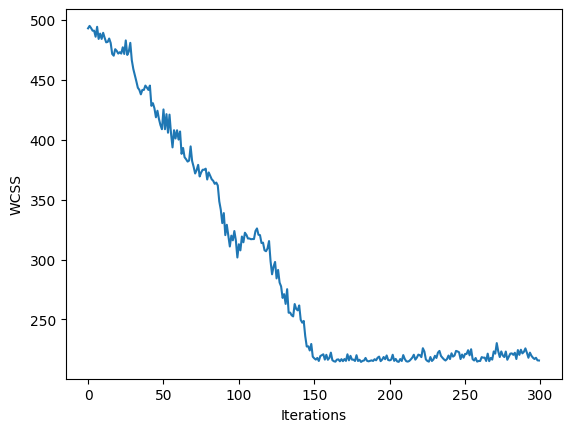

In [60]:
clustering_params = {
        'n_iter': iters,
        'n_seas': n_seas,
        'learning_rate': 3,
        'scheduling_factor':1,
        'min_len': 1,
        'mode': 'single',
        'starting_bp': np.random.randint(0, 365, n_seas),
        'metric': metric,
    }

model = Radially_Constrained_Cluster(array_tot, **clustering_params)

model.fit()

plt.plot(model.error_history)
plt.xlabel('Iterations')
plt.ylabel('WCSS')

er_b = model.error_history[-1]

In [61]:
err = np.zeros(2000)

for j in range(2000):

    tasms = np.random.permutation(array_tot)
    
    model = Radially_Constrained_Cluster(tasms, **clustering_params)

    model.fit()
    err[j] = model.error_history[-1]

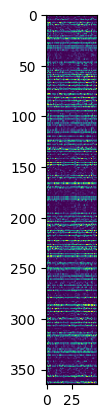

In [62]:
plt.imshow(tasms)

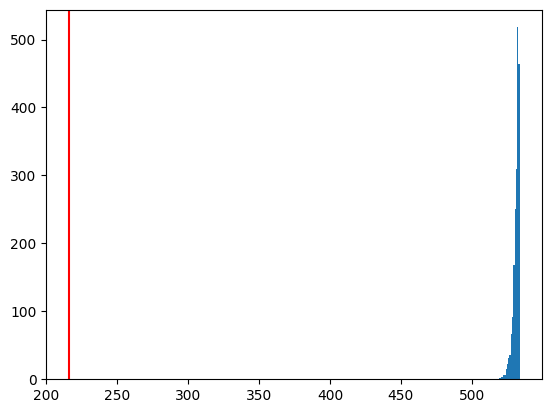

In [63]:
plt.hist(err, bins=20)
plt.axvline(er_b, color='r')